In [1]:
# LABS 4
# Creating a simple Bayesian model

In [2]:
# Using the data from following table create a model predicting number of passenger deaths.
# Use poisson distribution in two variants:
#     1. The rate is constant for all years and not depending on anything.
#     2. The intensity is constant, but rate is a product of intensity and miles flown.
# Select appropriate priors, perform prior predictive checks, fit the model and
# using posterior predictive distribution predict the death rates from the model.

In [3]:
import pandas as pd
import arviz as az
import numpy as np
import scipy.stats as stats

import matplotlib as mpl
import matplotlib.pyplot as plt

import pystan
import stan_utility

from DA_tools import ribbon_plot, light, light_highlight, mid, mid_highlight, dark, dark_highlight

In [4]:
# Seaborn & Matplotlib style configuration

light="#FFFCDC"
light_highlight="#FEF590"
mid="#FDED2A"
mid_highlight="#f0dc05"
dark="#EECA02"
dark_highlight="#BB9700"
green="#00FF00"
blue="#0000FF"
red="#FF0000"
light_grey="#DDDDDD"

st=plt.style.context('seaborn-white')
mpl.rcParams['figure.dpi']= 200

In [5]:
# ------------------------------------------------------------------------------
#                                     DATA
# ------------------------------------------------------------------------------

year            = [1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985]
fatal_accidents = [24, 25, 31, 31, 22, 21, 26, 20, 16, 22]
deaths          = [734, 516, 754, 877, 814, 362, 764, 809, 223, 1066]
death_rate      = [0.19, 0.12, 0.15, 0.16, 0.14, 0.06, 0.13, 0.13, 0.03, 0.15]
miles_flown     = [3863.0, 4300.0, 5027.0, 5481.0, 5814.0, 6033.0, 5877.0, 6223.0, 7433.0, 7107.0] # miles_flown = deaths / death_rate

# Data Frame
data = pd.DataFrame( { 'Year' : year,
                       'Fatal accidents' : fatal_accidents,
                       'Passenger deaths' : deaths,
                       'Death rate' : death_rate,
                       'Miles flown [100 mln miles]' : miles_flown
                     } ).set_index('Year')

In [6]:
data

,Fatal accidents,Passenger deaths,Death rate,Miles flown [100 mln miles]
Year,,,,
1976,24,734,0.19,3863.0
1977,25,516,0.12,4300.0
1978,31,754,0.15,5027.0
1979,31,877,0.16,5481.0
1980,22,814,0.14,5814.0
1981,21,362,0.06,6033.0
1982,26,764,0.13,5877.0
1983,20,809,0.13,6223.0
1984,16,223,0.03,7433.0


In [7]:
# Print passenger deaths per year
data['Passenger deaths']

Year
1976     734
1977     516
1978     754
1979     877
1980     814
1981     362
1982     764
1983     809
1984     223
1985    1066
Name: Passenger deaths, dtype: int64

(array([1., 1., 0., 1., 0., 0., 4., 2., 0., 1.]),
 array([ 223. ,  307.3,  391.6,  475.9,  560.2,  644.5,  728.8,  813.1,
         897.4,  981.7, 1066. ]),
 <a list of 10 Patch objects>)

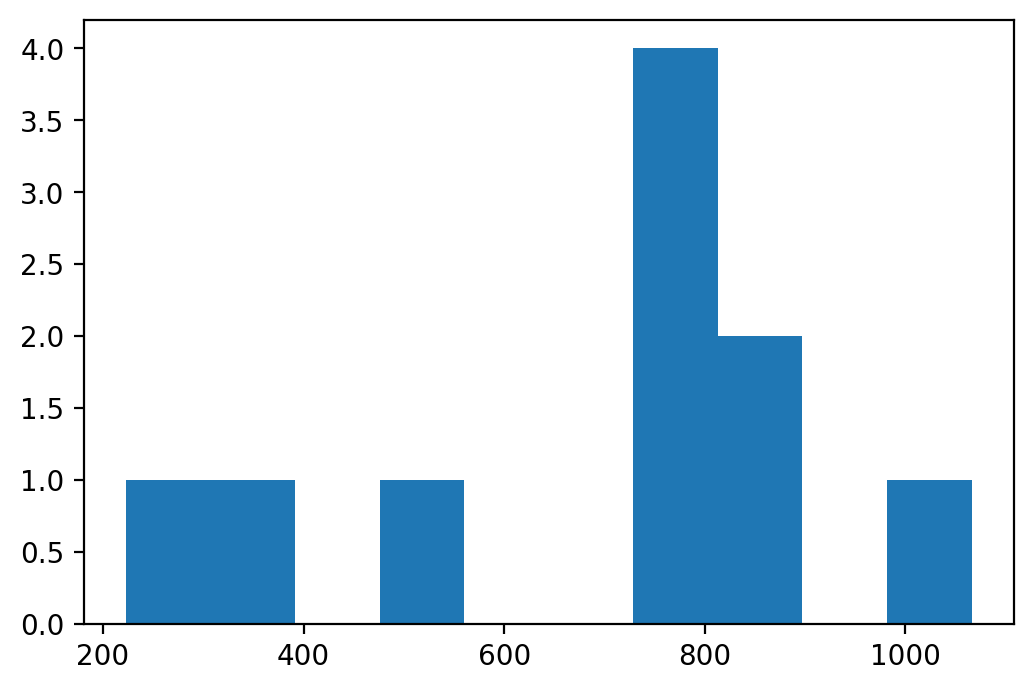

In [8]:
# Histogram of passenger deaths per year
plt.hist(data['Passenger deaths'])

In [9]:
# Calculate lambda (mean value)
Lambda_deaths = data['Passenger deaths'].mean()

print(Lambda_deaths)

691.9


In [10]:
# ------------------------------------------------------------------------------
#                                     1st MODEL
# ------------------------------------------------------------------------------

# rate = const (for all years)
# rate doesn't depend on anything

In [11]:
# ------------------------------------------------------------------------------
#                                     PRIOR FIT
# ------------------------------------------------------------------------------

# I used mean value of deaths (692) and wide sigma not to miss any possibilities

In [12]:
# Print file content
with open('prior_fit.stan', 'r') as file:
    print(file.read())

generated quantities {
	real lambda = normal_rng(692,200);
	int deaths = poisson_rng(lambda);
}



In [13]:
# Build model based on PRIOR_FIT file
model_prior_fit = stan_utility.compile_model('prior_fit.stan')

Using cached StanModel


In [14]:
# Simulate model

iterations = 1000
sim_prior_fit = model_prior_fit.sampling( data = dict(),
                                    iter       = iterations,
                                    warmup     = 0,
                                    refresh    = iterations,
                                    algorithm  = 'Fixed_param',
                                    seed       = 43541)

In [15]:
# Extract parameters of the simulation
params_prior_fit = sim_prior_fit.extract()

lambda_prior_fit = params_prior_fit['lambda']
deaths_prior_fit = params_prior_fit['deaths']

In [16]:
# Calculations & parameters used in plotting
x = np.linspace(0, 1500, 1500)
y = stats.norm.pdf(x, loc=692, scale=200)

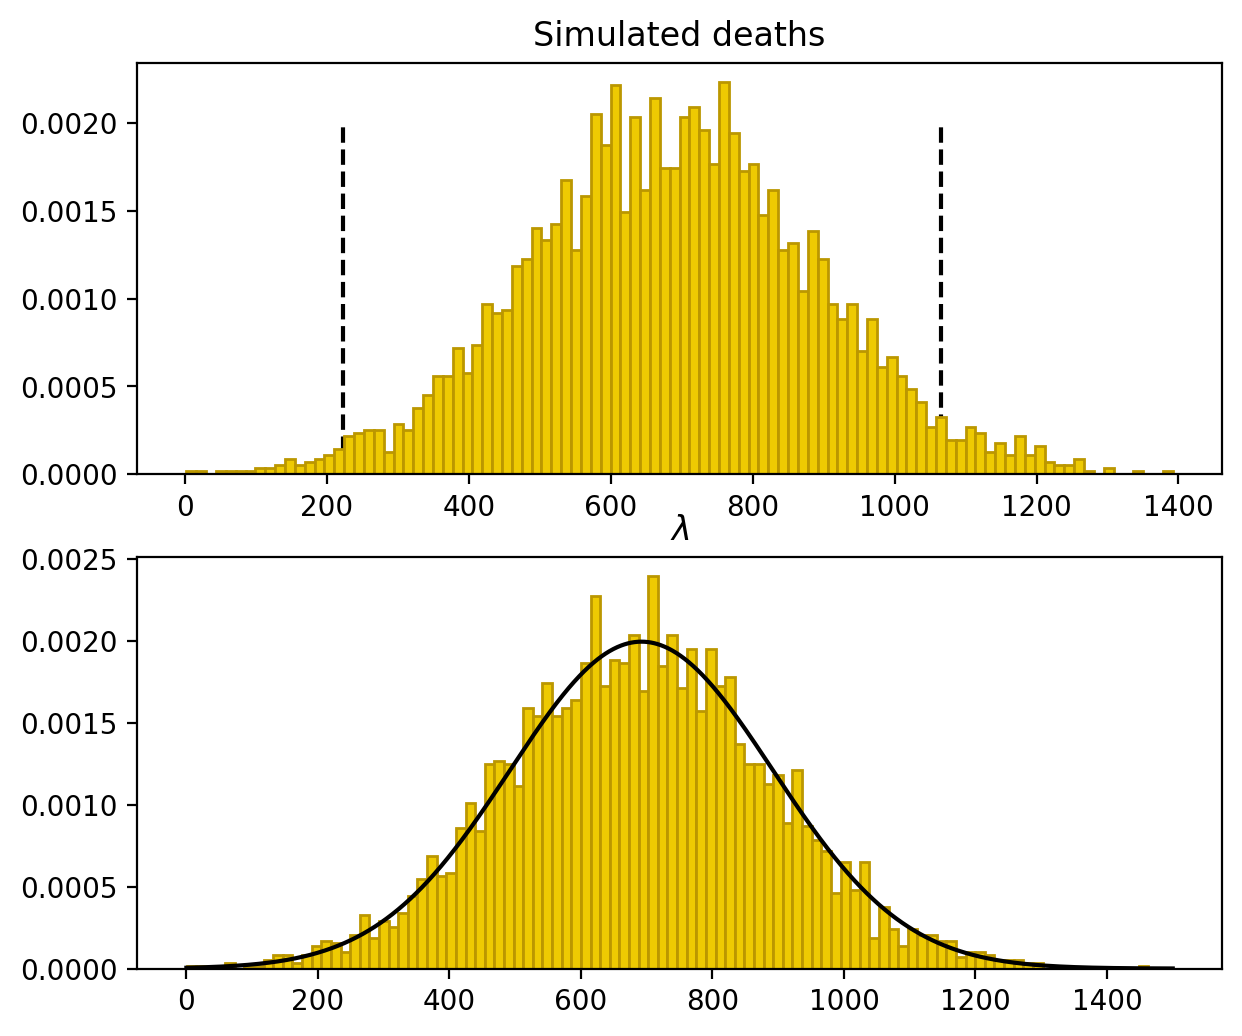

In [17]:
# Plots

plt.figure(figsize=(7, 6))

plt.subplot(2,1,1)
plt.hist(deaths_prior_fit, bins=100, color=dark, edgecolor=dark_highlight, density=True)
plt.vlines( [ data['Passenger deaths'].min(),
              data['Passenger deaths'].max()],
            ymin      = 0,
            ymax      = 2e-3,
            linestyle = '--',
            color     = 'black',
            zorder    = 1)
plt.title('Simulated deaths')

plt.subplot(2,1,2)
plt.hist(lambda_prior_fit, bins=100, color=dark, edgecolor=dark_highlight, density=True)
plt.plot(x,y,'black')
plt.title('$\lambda$')

plt.show()

In [18]:
# ------------------------------------------------------------------------------
#                                     FIT
# ------------------------------------------------------------------------------

In [19]:
# Print file content
with open('fit.stan', 'r') as file:
    print(file.read())

data {
	int N; //Number of samples
	int deaths[N]; //Deaths per year
}

parameters {
	real<lower=0> lambda;
}

model {
	lambda ~ normal(692,200);
	deaths ~ poisson(lambda);
}

generated quantities {
	int death = poisson_rng(lambda);
}



In [20]:
# Build model based on FIT file
model_fit = stan_utility.compile_model('fit.stan')

Using cached StanModel


In [21]:
# Simulate model
sim_data_dict = dict( N = len( data['Passenger deaths']),
                     deaths = data['Passenger deaths'])

sim_fit = model_fit.sampling( data = sim_data_dict,
                              seed = 43541)

In [22]:
# Print summary of the simulation
az.summary(sim_fit, var_names=['lambda'], round_to=2, kind='stats')

,mean,sd,hpd_3%,hpd_97%
lambda,691.68,8.31,676.52,707.67


In [23]:
# Extract parameters of the simulation
params_fit = sim_fit.extract()

lambda_fit = params_fit['lambda']
deaths_fit = params_fit['death']

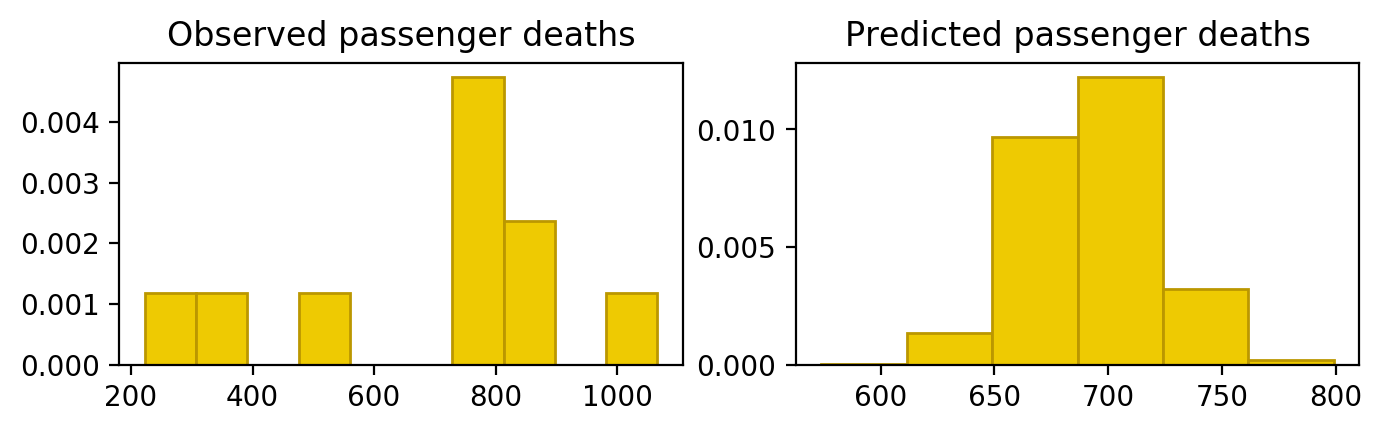

In [24]:
# Plots

plt.figure(figsize=(8,2))

plt.subplot(1,2,1)
plt.hist(data['Passenger deaths'], color=dark, edgecolor=dark_highlight, density=True)
plt.title('Observed passenger deaths')

plt.subplot(1,2,2)
plt.hist(deaths_fit, bins=6, color=dark, edgecolor=dark_highlight, density=True)
plt.title('Predicted passenger deaths')

plt.show()

In [25]:
# Mean value of death rate
invensivity = data['Death rate'].mean()
print(invensivity)

0.126


In [26]:
# ------------------------------------------------------------------------------
#                                     2nd MODEL
# ------------------------------------------------------------------------------

# intensivity = const (for all years)
# rate is a product of intensity and miles flown

In [27]:
# ------------------------------------------------------------------------------
#                                     PRIOR FIT
# ------------------------------------------------------------------------------

# Beta = invensivity
# beta_rng = beta distribution (interval between 0 to 1; no more than 1 person dead per 100 mld miles flown)
# I focus on variables between 0.2 and 0.8:
# alpha = 2
# beta = 10

In [28]:
# Print file content
with open('prior_fit_rate.stan', 'r') as file:
    print(file.read())

data {
	int N;
	real Miles[N];
}

generated quantities {
	real beta = beta_rng(2,10);
	int deaths[N];
	for(i in 1:N) {
		deaths[i] = poisson_rng(Miles[i]*beta);
	}
}



In [29]:
# Build model based on PRIOR_FIT_RATE file
model_prior_fit = stan_utility.compile_model('prior_fit_rate.stan')

Using cached StanModel


In [30]:
# Simulate model

iterations = 1000
sim_data_dict = dict( N     = 50,
                      Miles = np.linspace( data['Miles flown [100 mln miles]'].min(),
                                           data['Miles flown [100 mln miles]'].max()))

sim_prior_fit = model_prior_fit.sampling( data      = sim_data_dict,
                                          iter      = iterations,
                                          warmup    = 0,
                                          chains    = 1,
                                          refresh   = iterations,
                                          algorithm = 'Fixed_param',
                                          seed      = 43541)

In [31]:
# Extract parameters of the simulation
params_prior_fit = sim_prior_fit.extract()

beta_prior_fit   = params_prior_fit['beta']
deaths_prior_fit = params_prior_fit['deaths']

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


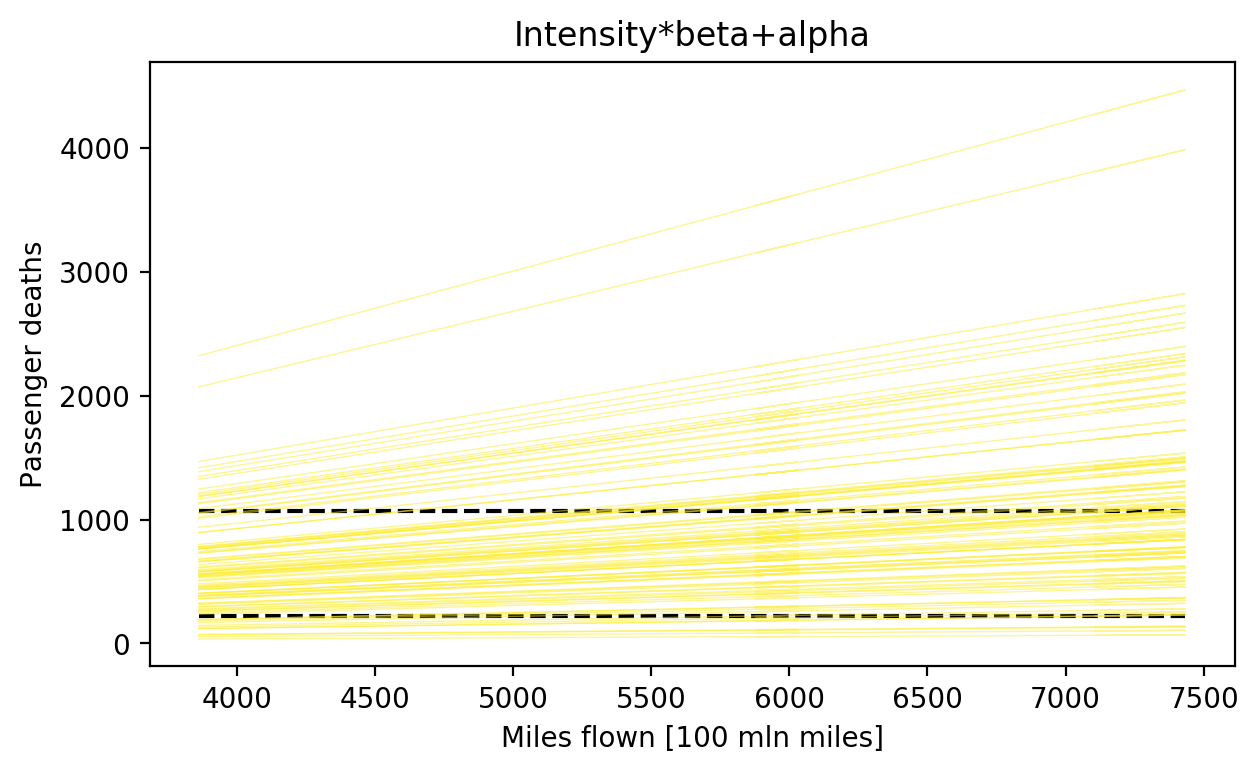

In [32]:
# Plots

plt.figure(figsize=(7, 4))

plt.hlines( [ data['Passenger deaths'].min(),
              data['Passenger deaths'].max() ],
            xmin       = data['Miles flown [100 mln miles]'].min(),
            xmax       = data['Miles flown [100 mln miles]'].max(),
            linestyles = '--',
            colors     = 'black')

for i in range(100):
    plt.plot( data['Miles flown [100 mln miles]'],
              beta_prior_fit[i]*data['Miles flown [100 mln miles]'],
              color     = mid,
              alpha     = 0.5,
              linewidth = 0.5)
    
plt.xlabel('Miles flown [100 mln miles]')
plt.ylabel('Passenger deaths')
plt.title('Intensity*beta+alpha')
plt.show()

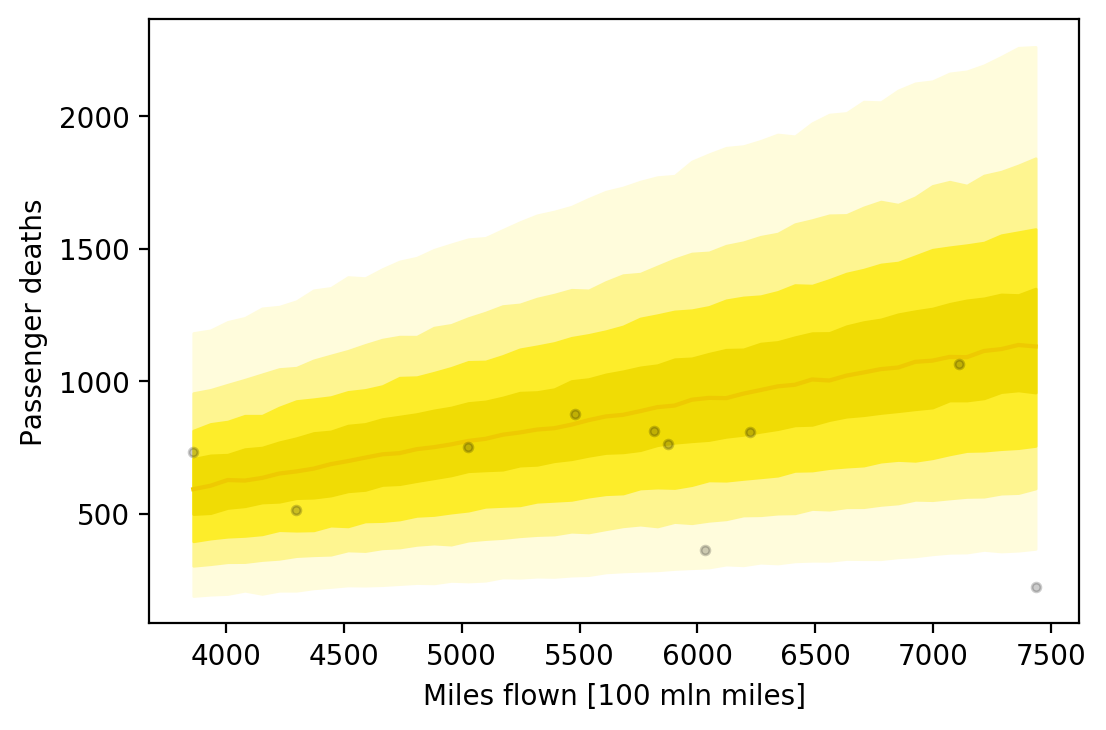

In [33]:
# Plots

fig, axes = plt.subplots(1,1, figsize=(6,4))

axes = ribbon_plot(sim_data_dict['Miles'], deaths_prior_fit, axes)
plt.scatter( data['Miles flown [100 mln miles]'],
             data['Passenger deaths'],
             color = 'black',
             alpha = 0.2,
             s     = 10)
plt.xlabel('Miles flown [100 mln miles]')
plt.ylabel('Passenger deaths')
plt.show()

In [34]:
# ------------------------------------------------------------------------------
#                                     FIT
# ------------------------------------------------------------------------------

In [35]:
# Print file content
with open('fit_rate.stan', 'r') as file:
    print(file.read())

data {
	int N; //Number of samples
	int deaths[N]; //Deaths per year
	vector[N] Miles;
}

parameters {
	real beta;
}

transformed parameters {
	vector[N] lambda = Miles*beta;
}

model {
	beta ~ beta(2,10);
	deaths ~ poisson(lambda);
}

generated quantities {
	int death[N];
	for (i in 1:N) {
		death[i] = poisson_rng(lambda[i]);
	}
}



In [36]:
# Build model based on FIT_RATE file
model_fit_rate = stan_utility.compile_model('fit_rate.stan')

Using cached StanModel


In [37]:
# Simulate model
sim_datarate_fit_dict = dict( N      = len(data),
                              deaths = data['Passenger deaths'],
                              Miles  = data['Miles flown [100 mln miles]'])

sim_fit_rate = model_fit_rate.sampling( data = sim_datarate_fit_dict,
                                        seed = 43541)

In [38]:
# Extract parameters of the simulation

params_fit_rate = sim_fit_rate.extract()

beta_fit_rate = params_fit_rate['beta']
lambda_fit_rate = params_fit_rate['lambda']
deaths_fit_rate_pred = params_fit_rate['death'] # Predicted number of deaths

In [39]:
# Print summary of the simulation
az.summary( sim_fit_rate,
            var_names = ['beta', 'lambda'],
            round_to  = 2,
            kind      = 'stats')

,mean,sd,hpd_3%,hpd_97%
beta,0.12,0.00,0.12,0.12
lambda[0],467.47,5.65,457.61,478.23
lambda[1],520.35,6.29,509.37,532.33
lambda[2],608.32,7.35,595.49,622.33
lambda[3],663.26,8.02,649.27,678.54
lambda[4],703.56,8.50,688.72,719.76
lambda[5],730.06,8.82,714.66,746.87
lambda[6],711.18,8.59,696.18,727.56
lambda[7],753.05,9.10,737.17,770.40
lambda[8],899.48,10.87,880.50,920.19


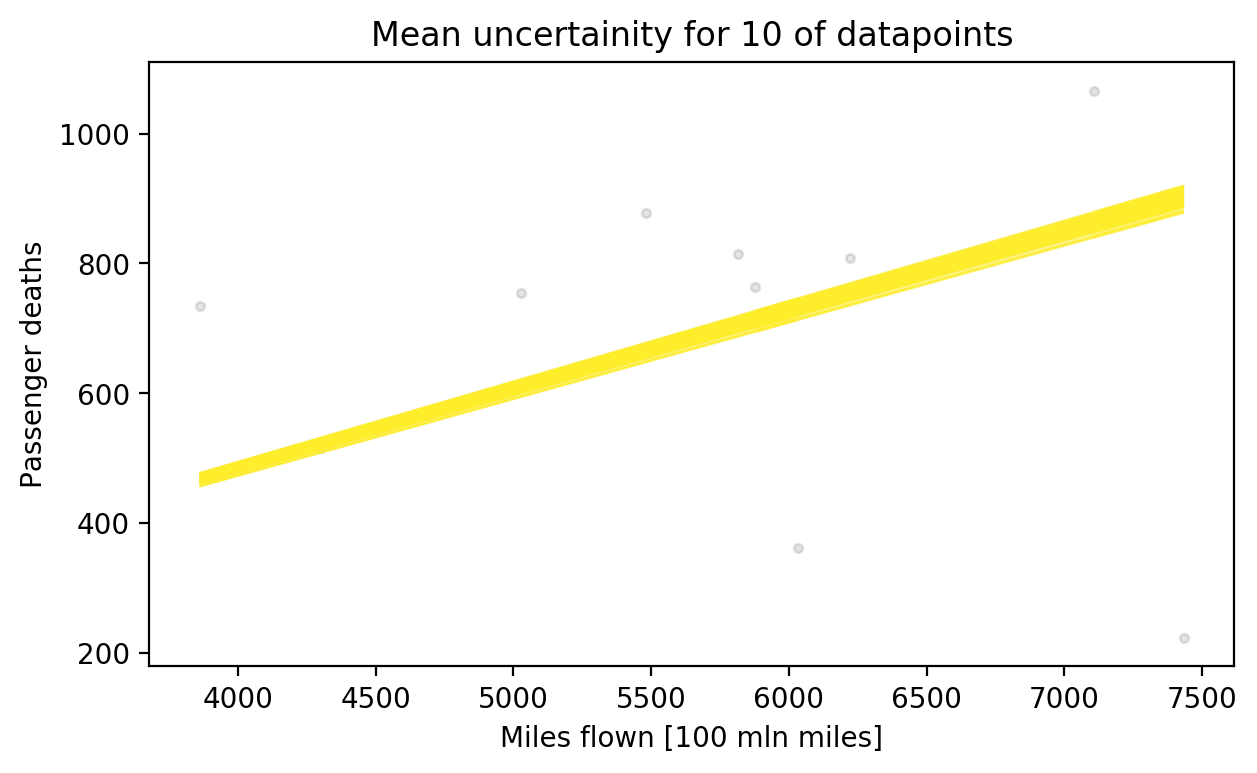

In [40]:
# Plots

plt.figure(figsize = (7, 4))

for i in range(100):
    plt.plot( data['Miles flown [100 mln miles]'],
               beta_fit_rate[i]*data['Miles flown [100 mln miles]'],
               color     = mid,
               alpha     = 0.5,
               linewidth = 0.5)
    
plt.scatter( data['Miles flown [100 mln miles]'],
              data['Passenger deaths'],
              color = 'black',
              alpha = 0.1,
              s     = 10)

plt.ylabel('Passenger deaths')
plt.xlabel('Miles flown [100 mln miles]')
plt.title('Mean uncertainity for {} of datapoints'.format(len(data)))
plt.show()

Sorting


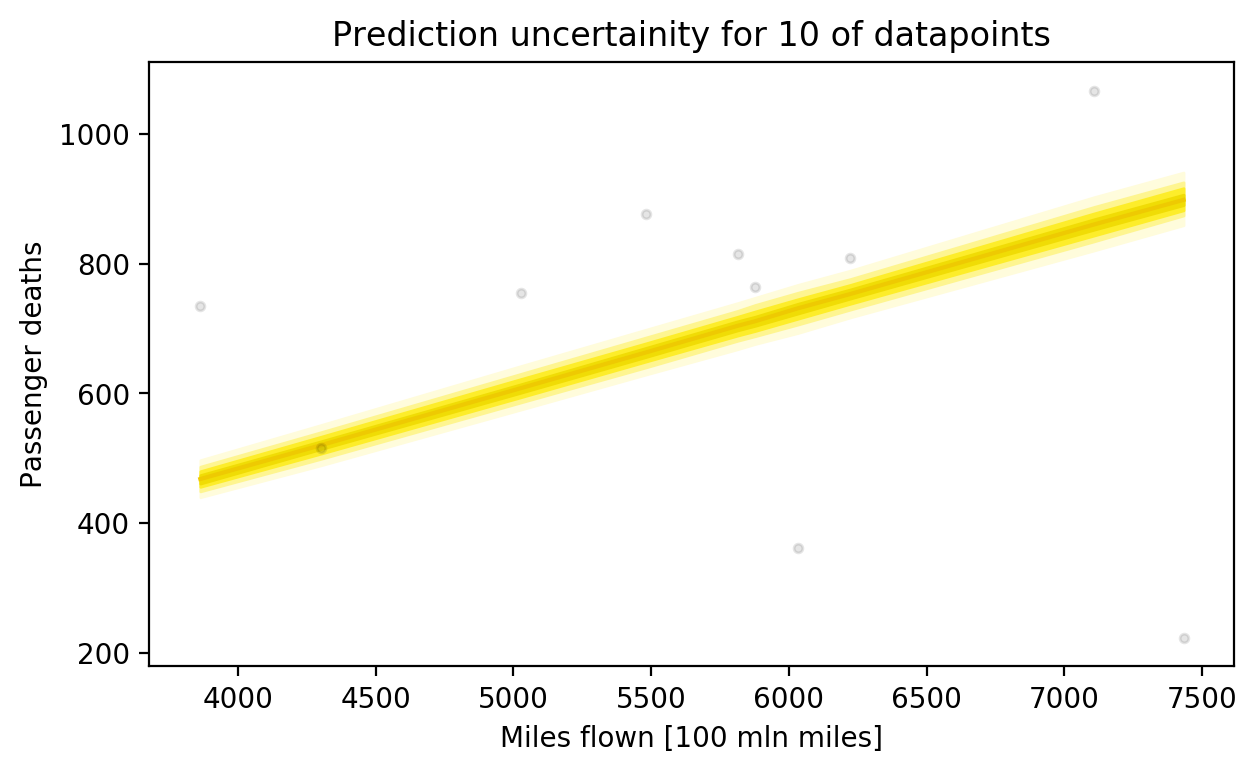

In [41]:
fig, axes = plt.subplots(1, 1, figsize=(7, 4))

axes = ribbon_plot( data['Miles flown [100 mln miles]'].values,
                    deaths_fit_rate_pred,
                    axes)

plt.scatter( data['Miles flown [100 mln miles]'],
             data['Passenger deaths'],
             color = 'black',
             alpha = 0.1,
             s     = 10)

plt.ylabel('Passenger deaths')
plt.xlabel('Miles flown [100 mln miles]')
plt.title('Prediction uncertainity for {} of datapoints'.format(len(data)))
plt.show()